In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy 
from collections import OrderedDict
from tqdm import tqdm
import pandas as pd
import torch.nn.functional as F
from collections import OrderedDict
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report 
import warnings
%matplotlib inline

In [2]:
# roll number
roll_num = 69
batch_size = 64
epochs = 7

## Loading Data

In [3]:
data_dir = 'A_05_Part_02_Dataset'

# Defining transformations
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])


In [4]:
class ImageFolderPath(datasets.ImageFolder):    
    def __getitem__(self, index):
        org_tuple = super(ImageFolderPath, self).__getitem__(index)
        path = self.imgs[index][0]
        return (org_tuple + (path,))

# Applying transformations on the data
train_data = ImageFolderPath(data_dir + '/Train', transform=train_transforms)
valid_data = ImageFolderPath(data_dir + '/Validation', transform=valid_transforms)
test_data = ImageFolderPath(data_dir + '/Test', transform=test_transforms)


# Data Loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)


print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['covid-19', 'normal', 'pneumonia']


## Showing Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


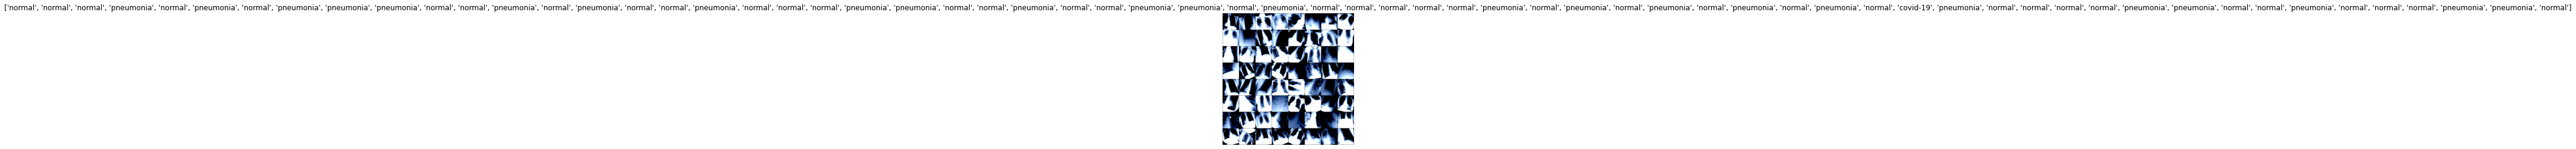

In [5]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes, paths = next(iter(trainloader))
show_databatch(inputs, classes)

## Loading Models

In [6]:
# Load the pretrained models from pytorch
vgg16 = models.vgg16(pretrained=True)


In [7]:
# resnet18 = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
resnet18 = models.resnet18(pretrained=True)

### Freezing the layers

In [8]:
# Freeze training for all layers
for param in vgg16.features.parameters():
    param.require_grad = False


In [ ]:

for param in resnet18.parameters():
    param.requires_grad = False


### Removing and Adding New Layers

In [ ]:
# Removing Last layer
num_features = vgg16.classifier[6].in_features

features = list(vgg16.classifier.children())[0:-1] # Remove last layer
features.extend([nn.Linear(num_features, len(class_names))])
vgg16.classifier = nn.Sequential(*features)


In [ ]:
# resnet18 = nn.Sequential(*list(resnet18.modules())[:-1]) # Remove last layer
resnet18.fc = nn.Sequential(OrderedDict([('fc1', nn.Linear(512, len(class_names)))]))

### Print

In [ ]:
print(vgg16)

In [ ]:
print(resnet18)

### Optimizer with BCELogitsLoss

In [ ]:
# Optimizer
criterion = nn.BCEWithLogitsLoss()
vgg16_optimizer = optim.SGD(vgg16.parameters(), lr=0.0001, momentum=0.9)


In [ ]:
criterion = nn.BCEWithLogitsLoss()
resnet18_optimizer = optim.SGD(resnet18.parameters(), lr=0.0001, momentum=0.9)

In [17]:
def hot_encoding_labels(labels):
     # One-Hot encoding
    encoder = OneHotEncoder(handle_unknown='ignore')
    labels_numpy = torch.Tensor.cpu(labels).detach().numpy().reshape(-1, 1)
    categories = np.array([[0], [1], [2]])
    encoder.fit(categories)
    encoded_labels = encoder.transform(labels_numpy).toarray()
    return encoded_labels

def covid_matrix_cal(covid_matrix, c_matrices):
    covid_matrix[0][0] = covid_matrix[0][0] + c_matrices[0][0][0]
    covid_matrix[0][1] = covid_matrix[0][1] + c_matrices[0][0][1]
    covid_matrix[1][0] = covid_matrix[1][0] + c_matrices[0][1][0]
    covid_matrix[1][1] = covid_matrix[1][1] + c_matrices[0][1][1]
    return covid_matrix

def pneumonia_matrix_cal(pneumonia_matrix, c_matrices):
    pneumonia_matrix[0][0] = pneumonia_matrix[0][0] + c_matrices[1][0][0]
    pneumonia_matrix[0][1] = pneumonia_matrix[0][1] + c_matrices[1][0][1]
    pneumonia_matrix[1][0] = pneumonia_matrix[1][0] + c_matrices[1][1][0]
    pneumonia_matrix[1][1] = pneumonia_matrix[1][1] + c_matrices[1][1][1]
    return pneumonia_matrix

def normal_matrix_cal(normal_matrix, c_matrices):
    normal_matrix[0][0] = normal_matrix[0][0] + c_matrices[2][0][0]
    normal_matrix[0][1] = normal_matrix[0][1] + c_matrices[2][0][1]
    normal_matrix[1][0] = normal_matrix[1][0] + c_matrices[2][1][0]
    normal_matrix[1][1] = normal_matrix[1][1] + c_matrices[2][1][1]
    return normal_matrix

def output_thresholding(outputs):
    for index, value in enumerate(outputs):
        if(value < 0.5):
            outputs[index] = 0
        else:
            outputs = 1
            
def covid_pneumonia(encoded_labels):
    # if covid == true than puenema = 1
    for row in range(encoded_labels.shape[0]):
        if encoded_labels[row][0] == 1:
            encoded_labels[row][2] = 1
    return encoded_labels
            
def plotting_accuracy(epochs, accuracy, colorBar, yLabel):

    print('*** ' + yLabel + ' ***')
    plt.figure(figsize=(10,5))
    plt.plot(range(epochs), accuracy, color=colorBar)
    plt.xlabel('Epochs')
    plt.ylabel(yLabel)
    plt.show()

def plotting_cros_entropy(epochs, accuracy, colorBar, yLabel):
    print('*** ' + yLabel + ' ***')
    plt.figure(figsize=(10,5))
    plt.plot(range(epochs), accuracy, color=colorBar)
    plt.xlabel('Epochs')
    plt.ylabel(yLabel)
    plt.show() 
    
def printing_confusion_table(covid_matrix):
    actual_labels = ["Actual False", "Actual True"]
    predicted_labels = ["Predicted False", "Predicted True"]
    print(pd.DataFrame(covid_matrix, actual_labels, predicted_labels))

## VGG

### Checking for GPU

In [ ]:
# Setting to either GPU or CPU based on availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

vgg16.train()

### Training

In [ ]:
vgg16_cross_entropy = []
vgg16_valid_accuracy = []

# Running Epochs
for epoch in range(epochs):

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels, paths = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        vgg16_optimizer.zero_grad()

        # forward + backward + optimize
        outputs = vgg16(inputs)             #----> forward pass
        
        # One-Hot encoding
        encoded_labels = hot_encoding_labels(labels)
        
        loss = criterion(outputs, torch.from_numpy(encoded_labels).to(device))   #----> compute loss
        loss.backward()                     #----> backward pass
        vgg16_optimizer.step()              #----> weights update
        
        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
    
    vgg16_cross_entropy.append(loss.data)
        
    torch.save(vgg16.state_dict(), 'vgg16_simple.pth')
    
    correct = 0
    total = 0
    
    covid_matrix = np.zeros((2,2))
    pneumonia_matrix = np.zeros((2,2))
    normal_matrix = np.zeros((2,2))
    
    with torch.no_grad():
        for data in validloader:
            images, labels, paths = data
            images, labels = images.to(device), labels.to(device)
            outputs = vgg16(images)
            
            # Applying sigmoid
            outputs = 1 / (1 + np.exp(-torch.Tensor.cpu(outputs).detach().numpy()))
            
            # Converting to 1 if greater than threshold of 0.5
            # if no value is greater than the threshold then defaulting to convert the max value to 1
            outputs[:] = np.where(outputs == outputs.max(axis=1).reshape(-1, 1), 1, outputs)
            outputs = np.where(outputs >= 0.5, 1, 0)
            
            # Converting output back to tensor 
            outputs = torch.from_numpy(outputs).to(device)
            
            # One-Hot encoding labels
            encoded_labels = hot_encoding_labels(labels)
            
            # Setting pneumonia to 1 if covid-19 is seen
            encoded_labels = covid_pneumonia(encoded_labels)
            
            encoded_labels = torch.from_numpy(encoded_labels).to(device)
               
            # Converting to numpy arrays for comparison
            outputs = torch.Tensor.cpu(outputs).detach().numpy()
            encoded_labels = torch.Tensor.cpu(encoded_labels).detach().numpy()
            
            
            total += labels.size(0)
            correct += np.all(outputs==encoded_labels, axis=1).sum()
            
            # Computing confusion matrices
            c_matrices = multilabel_confusion_matrix(encoded_labels, outputs)
            
            # Filling individual confusion matrices
            covid_matrix_cal(covid_matrix,c_matrices)
            pneumonia_matrix_cal(pneumonia_matrix, c_matrices)
            normal_matrix_cal(normal_matrix, c_matrices)
            
    vgg16_valid_accuracy.append((100 * correct / total))
    

### Printing

In [ ]:
print('VGG-16 Trained!!\n\n')
    
print('****** Scores ******')

print('VGG-16 Accuracy: ')   
scores = precision_recall_fscore_support(encoded_labels, outputs)
print('VGG-16 Precision:', scores[0])
print('VGG-16 Recall:', scores[1])
print('VGG-16 F1 Score:', scores[2])  
    
print('\n\n***** Covid-19 Confusion Matrix *****')
printing_confusion_table(covid_matrix)

print('\n\n***** Pneumonia Confusion Matrix *****')
printing_confusion_table(pneumonia_matrix)

print('\n\n***** Normal Confusion Matrix *****')
printing_confusion_table(normal_matrix)

### Plotting 

In [ ]:
plotting_accuracy(epochs, vgg16_valid_accuracy, 'green', 'Validation Accuracy')
plotting_cros_entropy(epochs, vgg16_cross_entropy, 'red', 'Cross Entropy')

### Testing Model

In [ ]:
# Saving Test results in CSV

df = pd.DataFrame()

with torch.no_grad():
    for data in testloader:
        images, labels, paths = data
        images, labels = images.to(device), labels.to(device)
        
        outputs = vgg16(images)
        
        # Applying sigmoid
        outputs = 1 / (1 + np.exp(-torch.Tensor.cpu(outputs).detach().numpy()))
            
        # Thresholding on output
        # if no value is greater than the threshold then defaulting to convert the max value to 1
        outputs[:] = np.where(outputs == outputs.max(axis=1).reshape(-1, 1), 1, outputs)
        outputs = np.where(outputs >= 0.5, 1, 0)
        
        images_paths = pd.DataFrame(paths)[0].str.split("/", expand = True).iloc[:,-1]
        current_batch_df = pd.concat([images_paths, pd.DataFrame(outputs)], axis=1, join='inner')
        
        # Changing columns' positions as instructed in the assignment brief  
        columns_titles = [9, 0, 2, 1]
        current_batch_df = current_batch_df.reindex(columns=columns_titles)
        
        current_batch_df.columns = [''] * len(current_batch_df.columns)
        current_batch_df.index = [''] * len(current_batch_df.index)
        
        df = df.append(current_batch_df)

# Restarting DataFrame's index
df.reset_index(drop=True)

# Saving to CSV
df.to_csv('MSDS19069_results1.csv', index=False, header=False)
print('VGG-16 Test Results Saved in CSV.')

## ResNet

### Checking for GPU

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

resnet18.train()

### Training

In [ ]:

resnet18_cross_entropy = []
resnet18_valid_accuracy = []

# Running Epochs
for epoch in range(epochs):

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels, paths = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        resnet18_optimizer.zero_grad()

        # forward + backward + optimize
        outputs = resnet18(inputs)               #----> forward pass
        
        # One-Hot encoding labels
        encoded_labels = hot_encoding_labels(labels)

        loss = criterion(outputs, torch.from_numpy(encoded_labels).to(device))   #----> compute loss
        loss.backward()                     #----> backward pass
        resnet18_optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
        
    resnet18_cross_entropy.append(loss.data)
        
    torch.save(resnet18.state_dict(), 'res18_simple.pth')
    
    correct = 0
    total = 0

    covid_matrix = np.zeros((2,2))
    pneumonia_matrix = np.zeros((2,2))
    normal_matrix = np.zeros((2,2))
    
    with torch.no_grad():
        for data in validloader:
            images, labels, paths = data
            images, labels = images.to(device), labels.to(device)
            outputs = resnet18(images)
            
            # Applying sigmoid
            outputs = 1 / (1 + np.exp(-torch.Tensor.cpu(outputs).detach().numpy()))
            
            # Converting to 1 if greater than threshold of 0.5
            # if no value is greater than the threshold then defaulting to convert the max value to 1
            outputs[:] = np.where(outputs == outputs.max(axis=1).reshape(-1, 1), 1, outputs)
            outputs = np.where(outputs >= 0.5, 1, 0)
            
            # Converting output back to tensor 
            outputs = torch.from_numpy(outputs).to(device)
            
            # One-Hot encoding labels
            encoded_labels = hot_encoding_labels(labels)
            
            
            # if covid == true than puenema = 1
            encoded_labels = covid_pneumonia(encoded_labels)        
            encoded_labels = torch.from_numpy(encoded_labels).to(device)
               
            # Converting to numpy arrays for comparison
            outputs = torch.Tensor.cpu(outputs).detach().numpy()
            encoded_labels = torch.Tensor.cpu(encoded_labels).detach().numpy()
            
            
            total += labels.size(0)
            correct += np.all(outputs==encoded_labels, axis=1).sum()
            
            # Computing confusion matrices
            c_matrices = multilabel_confusion_matrix(encoded_labels, outputs)
            
            # Filling individual confusion matrices
            covid_matrix_cal(covid_matrix,c_matrices)
            pneumonia_matrix_cal(pneumonia_matrix, c_matrices)
            normal_matrix_cal(normal_matrix, c_matrices)
    
    resnet18_valid_accuracy.append((100 * correct / total))

In [ ]:
print('ResNet-18 Trained!!\n\n')
    
print('****** Scores ******')
    
# Accuracy
print('ResNet-18 Accuracy: %d %%' % (100 * correct / total))   
scores = precision_recall_fscore_support(encoded_labels, outputs, average='weighted')
print('ResNet-18 Precision:', scores[0])
print('ResNet-18 Recall:', scores[1])
print('ResNet-18 F1 Score:', scores[2])  
    
print('\n\n***** Covid-19 Confusion Matrix *****')
printing_confusion_table(covid_matrix)

print('\n\n***** Pneumonia Confusion Matrix *****')
printing_confusion_table(pneumonia_matrix)

print('\n\n***** Normal Confusion Matrix *****')
printing_confusion_table(normal_matrix)

### Plotting

In [ ]:
plotting_accuracy(epochs, resnet18_valid_accuracy, 'green', 'Validation Accuracy')
plotting_cros_entropy(epochs, resnet18_cross_entropy, 'red', 'Cross Entropy')

### Testing and saving

In [ ]:
# Saving Test results in CSV

df = pd.DataFrame()

with torch.no_grad():
    for data in testloader:
        images, labels, paths = data
        images, labels = images.to(device), labels.to(device)
        
        outputs = resnet18(images)
        
        # Applying sigmoid
        outputs = 1 / (1 + np.exp(-torch.Tensor.cpu(outputs).detach().numpy()))
            
        # Converting to 1 if greater than threshold of 0.5
        # if no value is greater than the threshold then defaulting to convert the max value to 1
        outputs[:] = np.where(outputs == outputs.max(axis=1).reshape(-1, 1), 1, outputs)
        outputs = np.where(outputs >= 0.5, 1, 0)
        
        images_paths = pd.DataFrame(paths)[0].str.split("/", expand = True).iloc[:,-1]
        current_batch_df = pd.concat([images_paths, pd.DataFrame(outputs)], axis=1, join='inner')
        
        # Changing columns' positions as instructed in the assignment brief  
        columns_titles = [9, 0, 2, 1]
        current_batch_df = current_batch_df.reindex(columns=columns_titles)
        
        current_batch_df.columns = [''] * len(current_batch_df.columns)
        current_batch_df.index = [''] * len(current_batch_df.index)
        
        df = df.append(current_batch_df)


# Restarting DataFrame's index
df.reset_index(drop=True)

# Saving to CSV
df.to_csv('MSDS19069_results2.csv', index=False, header=False)
print('ResNet-18 Test Results Saved in CSV.')

# Focal Loss

In [9]:
# Load the pretrained models from pytorch
vgg16 = models.vgg16(pretrained=True)

# resnet18 = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
resnet18 = models.resnet18(pretrained=True)

### Freezing the layers

In [10]:
# Freeze training for all layers
for param in vgg16.features.parameters():
    param.require_grad = False

for param in resnet18.parameters():
    param.requires_grad = False


### Removing and Adding New Layers

In [11]:
# Removing Last layer
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[0:-1] # Remove last layer
features.extend([nn.Linear(num_features, len(class_names))])
vgg16.classifier = nn.Sequential(*features)

# resnet18 = nn.Sequential(*list(resnet18.modules())[:-1]) # Remove last layer
resnet18.fc = nn.Sequential(OrderedDict([('fc1', nn.Linear(512, len(class_names)))]))

### Focal Loss

In [12]:
class FocalLoss(torch.nn.Module):
    
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

        
    def forward(self, outputs, labels):
        outputs_sigmoid = torch.sigmoid(outputs)
        BCE_loss = F.binary_cross_entropy(outputs_sigmoid, labels, reduce=False)   
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * torch.Tensor.cpu((1-pt)**self.gamma * BCE_loss).detach().numpy()
        return np.mean(F_loss)

In [14]:
criterion = FocalLoss([0.3, 0.4, 0.6], 1.8)
vgg16_optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
resnet18_optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)

## VGG 

### Checking for GPU 

In [15]:
# Setting to either GPU or CPU based on availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

vgg16.train()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Training

In [18]:
vgg16_cross_entropy = []
vgg16_valid_accuracy = []

# Running Epochs
for epoch in range(epochs):

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels, paths = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        vgg16_optimizer.zero_grad()

        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass
        
        # One-Hot encoding labels
        encoded_labels = hot_encoding_labels(labels)
        
        outputs_numpy = torch.Tensor.cpu(outputs).detach().numpy()
        outputs = torch.from_numpy(encoded_labels).to(device)
        labels_numpy = torch.Tensor.cpu(torch.from_numpy(encoded_labels)).detach().numpy()
         
        loss = criterion(outputs, torch.from_numpy(encoded_labels).to(device))   #----> compute loss
        loss = torch.from_numpy(np.asarray(loss)).to(device)
        loss = Variable(loss, requires_grad = True)
        loss.backward()
        vgg16_optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss))
        
    vgg16_cross_entropy.append(loss.data)
        
    torch.save(vgg16.state_dict(), 'vgg16_focal_loss.pth')
    
    # Variables for accuracy, precision, recall and F1 score
    correct = 0
    total = 0
    
    covid_matrix = np.zeros((2,2))
    Pneumonia_matrix = np.zeros((2,2))
    normal_matrix = np.zeros((2,2))
    
    with torch.no_grad():
        for data in validloader:
            images, labels, paths = data
            images, labels = images.to(device), labels.to(device)
            outputs = vgg16(images)
            
            # Applying sigmoid
            outputs = 1 / (1 + np.exp(-torch.Tensor.cpu(outputs).detach().numpy()))
            
            # Converting to 1 if greater than threshold of 0.5
            outputs[:] = np.where(outputs == outputs.max(axis=1).reshape(-1, 1), 1, outputs)
            
#             outputs = output_thresholding(outputs)
            outputs = np.where(outputs >= 0.5, 1, 0)
            
            # Converting output back to tensor 
            outputs = torch.from_numpy(outputs).to(device)
            
            # One-Hot encoding labels
            encoded_labels = hot_encoding_labels(labels)
            
            # Setting pneumonia to 1 if covid-19 is seen
            encoded_labels = covid_pneumonia(encoded_labels)          
            encoded_labels = torch.from_numpy(encoded_labels).to(device)
               
            # Converting to numpy arrays for comparison
            outputs = torch.Tensor.cpu(outputs).detach().numpy()
            encoded_labels = torch.Tensor.cpu(encoded_labels).detach().numpy()
            
            
            total += labels.size(0)
            correct += np.all(outputs==encoded_labels, axis=1).sum()
            
            # Computing confusion matrices
            c_matrices = multilabel_confusion_matrix(encoded_labels, outputs)
            
            # Filling individual confusion matrices
            covid_matrix_cal(covid_matrix,c_matrices)
            pneumonia_matrix_cal(covid_matrix, c_matrices)
            normal_matrix_cal(normal_matrix, c_matrices)
            
    vgg16_valid_accuracy.append((100 * correct / total))
    
    

0it [00:00, ?it/s]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 0 [0/6200 (0%)]	Loss: 0.059317: : 1it [00:01,  1.87s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 0 [64/6200 (1%)]	Loss: 0.059847: : 2it [00:03,  1.78s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 0 [128/6200 (2%)]	Loss: 0.059317: : 3it [00:05,  1.77s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, pl

Train Epoch: 0 [3648/6200 (59%)]	Loss: 0.061437: : 58it [01:30,  1.52s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 0 [3712/6200 (60%)]	Loss: 0.058698: : 59it [01:31,  1.48s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 0 [3776/6200 (61%)]	Loss: 0.060730: : 60it [01:32,  1.46s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 0 [3840/6200 (62%)]	Loss: 0.060553: : 61it [01:34,  1.45s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:

Train Epoch: 0 [5504/6200 (89%)]	Loss: 0.059847: : 87it [02:12,  1.45s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 0 [5568/6200 (90%)]	Loss: 0.060112: : 88it [02:14,  1.45s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 0 [5632/6200 (91%)]	Loss: 0.060288: : 89it [02:15,  1.45s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 0 [5696/6200 (92%)]	Loss: 0.059405: : 90it [02:17,  1.45s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:

Train Epoch: 1 [1152/6200 (19%)]	Loss: 0.059847: : 19it [00:28,  1.52s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 1 [1216/6200 (20%)]	Loss: 0.060553: : 20it [00:29,  1.47s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 1 [1280/6200 (21%)]	Loss: 0.060995: : 21it [00:30,  1.50s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 1 [1344/6200 (22%)]	Loss: 0.059935: : 22it [00:32,  1.47s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:

Train Epoch: 1 [3008/6200 (48%)]	Loss: 0.058875: : 48it [01:11,  1.47s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 1 [3072/6200 (49%)]	Loss: 0.059405: : 49it [01:12,  1.46s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 1 [3136/6200 (51%)]	Loss: 0.060818: : 50it [01:14,  1.44s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 1 [3200/6200 (52%)]	Loss: 0.060995: : 51it [01:15,  1.49s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:

Train Epoch: 1 [4864/6200 (78%)]	Loss: 0.060995: : 77it [01:55,  1.56s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 1 [4928/6200 (79%)]	Loss: 0.058963: : 78it [01:56,  1.52s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 1 [4992/6200 (80%)]	Loss: 0.059847: : 79it [01:58,  1.58s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 1 [5056/6200 (81%)]	Loss: 0.059935: : 80it [02:00,  1.54s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:

Train Epoch: 2 [512/6200 (8%)]	Loss: 0.061260: : 9it [00:12,  1.38s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 2 [576/6200 (9%)]	Loss: 0.059405: : 10it [00:13,  1.38s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 2 [640/6200 (10%)]	Loss: 0.059405: : 11it [00:15,  1.39s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 2 [704/6200 (11%)]	Loss: 0.060995: : 12it [00:16,  1.40s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: Use

Train Epoch: 2 [2368/6200 (38%)]	Loss: 0.060995: : 38it [00:53,  1.42s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 2 [2432/6200 (39%)]	Loss: 0.060730: : 39it [00:55,  1.42s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 2 [2496/6200 (40%)]	Loss: 0.060200: : 40it [00:56,  1.48s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 2 [2560/6200 (41%)]	Loss: 0.060112: : 41it [00:58,  1.50s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:

Train Epoch: 2 [4224/6200 (68%)]	Loss: 0.061702: : 67it [01:36,  1.41s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 2 [4288/6200 (69%)]	Loss: 0.058698: : 68it [01:37,  1.40s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 2 [4352/6200 (70%)]	Loss: 0.060730: : 69it [01:38,  1.43s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 2 [4416/6200 (71%)]	Loss: 0.060377: : 70it [01:40,  1.50s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:

Train Epoch: 2 [6080/6200 (98%)]	Loss: 0.060553: : 96it [02:20,  1.52s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 2 [5376/6200 (99%)]	Loss: 0.060717: : 97it [02:21,  1.46s/it]
0it [00:00, ?it/s]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 3 [0/6200 (0%)]	Loss: 0.060907: : 1it [00:01,  1.63s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 3 [64/6200 (1%)]	Loss: 0.059935: : 2it [00:03,  1.58s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_red

Train Epoch: 3 [1728/6200 (28%)]	Loss: 0.061702: : 28it [00:40,  1.46s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 3 [1792/6200 (29%)]	Loss: 0.060818: : 29it [00:42,  1.43s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 3 [1856/6200 (30%)]	Loss: 0.060553: : 30it [00:43,  1.41s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 3 [1920/6200 (31%)]	Loss: 0.059317: : 31it [00:44,  1.42s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:

Train Epoch: 3 [3584/6200 (58%)]	Loss: 0.059052: : 57it [01:23,  1.44s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 3 [3648/6200 (59%)]	Loss: 0.060023: : 58it [01:24,  1.42s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 3 [3712/6200 (60%)]	Loss: 0.060377: : 59it [01:26,  1.41s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 3 [3776/6200 (61%)]	Loss: 0.059847: : 60it [01:27,  1.45s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:

Train Epoch: 3 [5440/6200 (88%)]	Loss: 0.060465: : 86it [02:05,  1.52s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 3 [5504/6200 (89%)]	Loss: 0.059935: : 87it [02:07,  1.52s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 3 [5568/6200 (90%)]	Loss: 0.060642: : 88it [02:08,  1.55s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 3 [5632/6200 (91%)]	Loss: 0.059935: : 89it [02:10,  1.49s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:

Train Epoch: 4 [1088/6200 (18%)]	Loss: 0.060995: : 18it [00:25,  1.45s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 4 [1152/6200 (19%)]	Loss: 0.061525: : 19it [00:27,  1.45s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 4 [1216/6200 (20%)]	Loss: 0.060288: : 20it [00:28,  1.44s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 4 [1280/6200 (21%)]	Loss: 0.060200: : 21it [00:30,  1.45s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:

Train Epoch: 4 [2944/6200 (47%)]	Loss: 0.060642: : 47it [01:08,  1.43s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 4 [3008/6200 (48%)]	Loss: 0.060023: : 48it [01:09,  1.39s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 4 [3072/6200 (49%)]	Loss: 0.060730: : 49it [01:11,  1.40s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 4 [3136/6200 (51%)]	Loss: 0.059847: : 50it [01:12,  1.41s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:

Train Epoch: 4 [4800/6200 (77%)]	Loss: 0.061260: : 76it [01:52,  1.53s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 4 [4864/6200 (78%)]	Loss: 0.060465: : 77it [01:53,  1.58s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 4 [4928/6200 (79%)]	Loss: 0.059317: : 78it [01:55,  1.64s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 4 [4992/6200 (80%)]	Loss: 0.060465: : 79it [01:57,  1.59s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:

Train Epoch: 5 [448/6200 (7%)]	Loss: 0.059140: : 8it [00:12,  1.54s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 5 [512/6200 (8%)]	Loss: 0.059405: : 9it [00:13,  1.50s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 5 [576/6200 (9%)]	Loss: 0.060995: : 10it [00:14,  1.47s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 5 [640/6200 (10%)]	Loss: 0.060907: : 11it [00:16,  1.46s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserW

Train Epoch: 5 [2304/6200 (37%)]	Loss: 0.059670: : 37it [00:54,  1.44s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 5 [2368/6200 (38%)]	Loss: 0.060465: : 38it [00:55,  1.43s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 5 [2432/6200 (39%)]	Loss: 0.059935: : 39it [00:57,  1.42s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 5 [2496/6200 (40%)]	Loss: 0.060818: : 40it [00:58,  1.44s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:

Train Epoch: 5 [4160/6200 (67%)]	Loss: 0.059228: : 66it [01:36,  1.36s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 5 [4224/6200 (68%)]	Loss: 0.060288: : 67it [01:38,  1.39s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 5 [4288/6200 (69%)]	Loss: 0.060023: : 68it [01:39,  1.36s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 5 [4352/6200 (70%)]	Loss: 0.061083: : 69it [01:41,  1.39s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:

Train Epoch: 5 [6016/6200 (97%)]	Loss: 0.060730: : 95it [02:20,  1.44s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 5 [6080/6200 (98%)]	Loss: 0.060112: : 96it [02:22,  1.52s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 5 [5376/6200 (99%)]	Loss: 0.060112: : 97it [02:23,  1.48s/it]
0it [00:00, ?it/s]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 6 [0/6200 (0%)]	Loss: 0.060642: : 1it [00:01,  1.40s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/

Train Epoch: 6 [1664/6200 (27%)]	Loss: 0.059405: : 27it [00:40,  1.47s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 6 [1728/6200 (28%)]	Loss: 0.060907: : 28it [00:42,  1.44s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 6 [1792/6200 (29%)]	Loss: 0.059405: : 29it [00:43,  1.42s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 6 [1856/6200 (30%)]	Loss: 0.060465: : 30it [00:45,  1.40s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:

Train Epoch: 6 [3520/6200 (57%)]	Loss: 0.060730: : 56it [01:23,  1.47s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 6 [3584/6200 (58%)]	Loss: 0.059317: : 57it [01:25,  1.48s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 6 [3648/6200 (59%)]	Loss: 0.060465: : 58it [01:26,  1.43s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 6 [3712/6200 (60%)]	Loss: 0.059140: : 59it [01:27,  1.42s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:

Train Epoch: 6 [5376/6200 (87%)]	Loss: 0.060465: : 85it [02:06,  1.47s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 6 [5440/6200 (88%)]	Loss: 0.059847: : 86it [02:07,  1.51s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 6 [5504/6200 (89%)]	Loss: 0.060907: : 87it [02:09,  1.48s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 6 [5568/6200 (90%)]	Loss: 0.059670: : 88it [02:10,  1.46s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:

In [19]:
print('VGG-16 Trained!!\n\n')
    
print('****** Scores ******')
    
# Accuracy
print('VGG-16 Accuracy: %d %%' % (100 * correct / total))   
scores = precision_recall_fscore_support(encoded_labels, outputs, average='weighted')
print('VGG-16 Precision:', scores[0])
print('VGG-16 Recall:', scores[1])
print('VGG-16 F1 Score:', scores[2])  
    
print('\n\n***** Covid-19 Confusion Matrix *****')
printing_confusion_table(covid_matrix)

print('\n\n***** Pneumonia Confusion Matrix *****')
printing_confusion_table(pneumonia_matrix_cal)

print('\n\n***** Normal Confusion Matrix *****')
printing_confusion_table(normal_matrix)

VGG-16 Trained!!


****** Scores ******
VGG-16 Accuracy: 27 %
VGG-16 Precision: 0.4119618711270253
VGG-16 Recall: 0.5263157894736842
VGG-16 F1 Score: 0.4619560512311258


***** Covid-19 Confusion Matrix *****
              Predicted False  Predicted True
Actual False            498.0           330.0
Actual True             114.0           314.0


***** Pneumonia Confusion Matrix *****
                                                Predicted False  \
Actual False  <function pneumonia_matrix_cal at 0x7f8f66b07b70>   
Actual True   <function pneumonia_matrix_cal at 0x7f8f66b07b70>   

                                                 Predicted True  
Actual False  <function pneumonia_matrix_cal at 0x7f8f66b07b70>  
Actual True   <function pneumonia_matrix_cal at 0x7f8f66b07b70>  


***** Normal Confusion Matrix *****
              Predicted False  Predicted True
Actual False            204.0           196.0
Actual True             126.0           102.0


### Plotting

*** Validation Accuracy ***


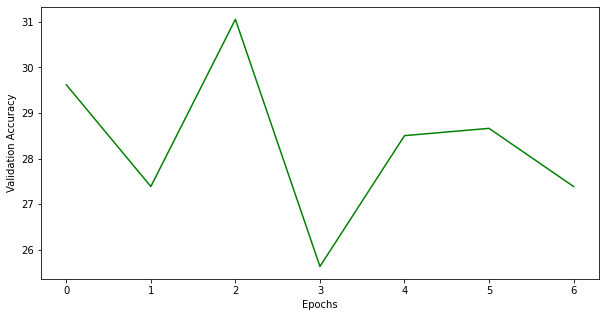

*** Cross Entropy ***


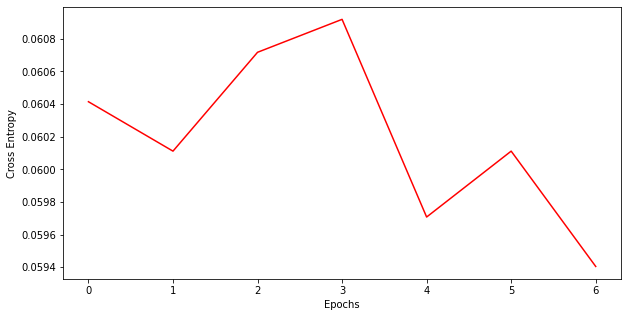

In [20]:
plotting_accuracy(epochs, vgg16_valid_accuracy, 'green', 'Validation Accuracy')
plotting_cros_entropy(epochs, vgg16_cross_entropy, 'red', 'Cross Entropy')

### Testing

In [21]:
# Saving Test results in CSV

df = pd.DataFrame()

with torch.no_grad():
    for data in testloader:
        images, labels, paths = data
        images, labels = images.to(device), labels.to(device)
        
        outputs = vgg16(images)
        
        # Applying sigmoid
        outputs = 1 / (1 + np.exp(-torch.Tensor.cpu(outputs).detach().numpy()))
            
        # Converting to 1 if greater than threshold of 0.5
        outputs[:] = np.where(outputs == outputs.max(axis=1).reshape(-1, 1), 1, outputs)
        outputs = np.where(outputs >= 0.5, 1, 0)
        
        images_paths = pd.DataFrame(paths)[0].str.split("/", expand = True).iloc[:,-1]
        current_batch_df = pd.concat([images_paths, pd.DataFrame(outputs)], axis=1, join='inner')
        
        # Changing columns' positions as instructed in the assignment brief  
        columns_titles = [9, 0, 2, 1]
        current_batch_df = current_batch_df.reindex(columns=columns_titles)
        
        current_batch_df.columns = [''] * len(current_batch_df.columns)
        current_batch_df.index = [''] * len(current_batch_df.index)
        
        df = df.append(current_batch_df)


# Restarting DataFrame's index
df.reset_index(drop=True)

# Saving to CSV
df.to_csv('MSDS19069_results3.csv', index=False, header=False)
print('VGG-16 Test Results Saved in CSV.')

VGG-16 Test Results Saved in CSV.


## ResNet 18

### Checking For GPU

In [23]:
# Setting to either GPU or CPU based on availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

resnet18.train()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Training

In [24]:
resnet18_cross_entropy = []
resnet18_valid_accuracy = []

# Running Epochs
for epoch in range(epochs):

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels, paths = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        resnet18_optimizer.zero_grad()

        # forward + backward + optimize
        outputs = resnet18(inputs)               #----> forward pass
                
        # One-Hot encoding labels
        encoded_labels = hot_encoding_labels(labels)
        
        outputs_numpy = torch.Tensor.cpu(outputs).detach().numpy()
        outputs = torch.from_numpy(encoded_labels).to(device)
        labels_numpy = torch.Tensor.cpu(torch.from_numpy(encoded_labels)).detach().numpy()
         
        loss = criterion(outputs, torch.from_numpy(encoded_labels).to(device))   #----> compute loss
        loss = torch.from_numpy(np.asarray(loss)).to(device)
        loss = Variable(loss, requires_grad = True)
        
        loss.backward()                     #----> backward pass
        resnet18_optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.data))
        
    resnet18_cross_entropy.append(loss.data)
        
    torch.save(resnet18.state_dict(), 'res18_focal_loss.pth')
    
    # Variables for accuracy, precision, recall and F1 score
    correct = 0
    total = 0
    
    
    covid_matrix = np.zeros((2,2))
    pneumonia_matrix = np.zeros((2,2))
    normal_matrix = np.zeros((2,2))
    
    with torch.no_grad():
        for data in validloader:
            images, labels, paths = data
            images, labels = images.to(device), labels.to(device)
            outputs = vgg16(images)
            
            # Applying sigmoid
            outputs = 1 / (1 + np.exp(-torch.Tensor.cpu(outputs).detach().numpy()))
            
            # Converting to 1 if greater than threshold of 0.5
            # if no value is greater than the threshold then defaulting to convert the max value to 1
            outputs[:] = np.where(outputs == outputs.max(axis=1).reshape(-1, 1), 1, outputs)
            outputs = np.where(outputs >= 0.5, 1, 0)
#             outputs = hot_encoding_labels(outputs)
            
            # Converting output back to tensor 
            outputs = torch.from_numpy(outputs).to(device)
            
            # One-Hot encoding labels
            encoded_labels = hot_encoding_labels(labels)
            
            # Setting pneumonia to 1 if covid-19 is seen
            encoded_labels = covid_pneumonia(encoded_labels)
            
            encoded_labels = torch.from_numpy(encoded_labels).to(device)
               
            # Converting to numpy arrays for comparison
            outputs = torch.Tensor.cpu(outputs).detach().numpy()
            encoded_labels = torch.Tensor.cpu(encoded_labels).detach().numpy()
            
            total += labels.size(0)
            correct += np.all(outputs==encoded_labels, axis=1).sum()
            
            # Computing confusion matrices
            c_matrices = multilabel_confusion_matrix(encoded_labels, outputs)
            
            # Filling individual confusion matrices
            covid_matrix = covid_matrix_cal(covid_matrix, c_matrices)

            pneumonia_matrix = pneumonia_matrix_cal(pneumonia_matrix , c_matrices)

            normal_matrix = normal_matrix_cal(normal_matrix , c_matrices)

    
    resnet18_valid_accuracy.append((100 * correct / total))

0it [00:00, ?it/s]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 0 [0/6200 (0%)]	Loss: 0.059847: : 1it [00:01,  1.45s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 0 [64/6200 (1%)]	Loss: 0.061083: : 2it [00:03,  1.48s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 0 [128/6200 (2%)]	Loss: 0.060288: : 3it [00:04,  1.50s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, pl

Train Epoch: 0 [3648/6200 (59%)]	Loss: 0.059052: : 58it [01:18,  1.28s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 0 [3712/6200 (60%)]	Loss: 0.059317: : 59it [01:19,  1.27s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 0 [3776/6200 (61%)]	Loss: 0.060377: : 60it [01:20,  1.29s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 0 [3840/6200 (62%)]	Loss: 0.059670: : 61it [01:22,  1.29s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:

Train Epoch: 0 [5504/6200 (89%)]	Loss: 0.059758: : 87it [01:57,  1.39s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 0 [5568/6200 (90%)]	Loss: 0.060818: : 88it [01:58,  1.35s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 0 [5632/6200 (91%)]	Loss: 0.060112: : 89it [01:59,  1.32s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 0 [5696/6200 (92%)]	Loss: 0.060023: : 90it [02:01,  1.30s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:

Train Epoch: 1 [1152/6200 (19%)]	Loss: 0.059847: : 19it [00:25,  1.29s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 1 [1216/6200 (20%)]	Loss: 0.061172: : 20it [00:26,  1.29s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 1 [1280/6200 (21%)]	Loss: 0.059228: : 21it [00:27,  1.27s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 1 [1344/6200 (22%)]	Loss: 0.060023: : 22it [00:28,  1.25s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:

Train Epoch: 1 [3008/6200 (48%)]	Loss: 0.060288: : 48it [01:05,  1.32s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 1 [3072/6200 (49%)]	Loss: 0.061260: : 49it [01:06,  1.49s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 1 [3136/6200 (51%)]	Loss: 0.060907: : 50it [01:08,  1.53s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 1 [3200/6200 (52%)]	Loss: 0.059847: : 51it [01:09,  1.45s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:

Train Epoch: 1 [4864/6200 (78%)]	Loss: 0.060377: : 77it [01:44,  1.29s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 1 [4928/6200 (79%)]	Loss: 0.058787: : 78it [01:45,  1.28s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 1 [4992/6200 (80%)]	Loss: 0.060023: : 79it [01:47,  1.28s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 1 [5056/6200 (81%)]	Loss: 0.061083: : 80it [01:48,  1.34s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:

Train Epoch: 2 [512/6200 (8%)]	Loss: 0.059847: : 9it [00:12,  1.29s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 2 [576/6200 (9%)]	Loss: 0.059758: : 10it [00:13,  1.41s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 2 [640/6200 (10%)]	Loss: 0.059228: : 11it [00:15,  1.43s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 2 [704/6200 (11%)]	Loss: 0.060023: : 12it [00:16,  1.51s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: Use

Train Epoch: 2 [2368/6200 (38%)]	Loss: 0.061967: : 38it [00:51,  1.28s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 2 [2432/6200 (39%)]	Loss: 0.060023: : 39it [00:52,  1.29s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 2 [2496/6200 (40%)]	Loss: 0.061348: : 40it [00:53,  1.30s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 2 [2560/6200 (41%)]	Loss: 0.059405: : 41it [00:55,  1.28s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:

Train Epoch: 2 [4224/6200 (68%)]	Loss: 0.061172: : 67it [01:31,  1.43s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 2 [4288/6200 (69%)]	Loss: 0.059847: : 68it [01:32,  1.44s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 2 [4352/6200 (70%)]	Loss: 0.060642: : 69it [01:34,  1.47s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 2 [4416/6200 (71%)]	Loss: 0.060465: : 70it [01:35,  1.40s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:

Train Epoch: 2 [6080/6200 (98%)]	Loss: 0.060377: : 96it [02:09,  1.35s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 2 [5376/6200 (99%)]	Loss: 0.059203: : 97it [02:11,  1.35s/it]
0it [00:00, ?it/s]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 3 [0/6200 (0%)]	Loss: 0.060023: : 1it [00:01,  1.52s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 3 [64/6200 (1%)]	Loss: 0.059935: : 2it [00:03,  1.52s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_red

Train Epoch: 3 [1728/6200 (28%)]	Loss: 0.060818: : 28it [00:37,  1.44s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 3 [1792/6200 (29%)]	Loss: 0.058168: : 29it [00:39,  1.51s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 3 [1856/6200 (30%)]	Loss: 0.060465: : 30it [00:40,  1.43s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 3 [1920/6200 (31%)]	Loss: 0.061790: : 31it [00:41,  1.37s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:

Train Epoch: 3 [3584/6200 (58%)]	Loss: 0.059670: : 57it [01:16,  1.37s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 3 [3648/6200 (59%)]	Loss: 0.060023: : 58it [01:17,  1.33s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 3 [3712/6200 (60%)]	Loss: 0.059493: : 59it [01:18,  1.32s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 3 [3776/6200 (61%)]	Loss: 0.060465: : 60it [01:20,  1.30s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:

Train Epoch: 3 [5440/6200 (88%)]	Loss: 0.059493: : 86it [01:54,  1.29s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 3 [5504/6200 (89%)]	Loss: 0.059758: : 87it [01:55,  1.27s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 3 [5568/6200 (90%)]	Loss: 0.059228: : 88it [01:57,  1.30s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 3 [5632/6200 (91%)]	Loss: 0.059493: : 89it [01:58,  1.29s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:

Train Epoch: 4 [1088/6200 (18%)]	Loss: 0.060377: : 18it [00:24,  1.38s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 4 [1152/6200 (19%)]	Loss: 0.060465: : 19it [00:25,  1.34s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 4 [1216/6200 (20%)]	Loss: 0.059847: : 20it [00:27,  1.33s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 4 [1280/6200 (21%)]	Loss: 0.060112: : 21it [00:28,  1.33s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:

Train Epoch: 4 [2944/6200 (47%)]	Loss: 0.059935: : 47it [01:03,  1.35s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 4 [3008/6200 (48%)]	Loss: 0.059935: : 48it [01:04,  1.32s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 4 [3072/6200 (49%)]	Loss: 0.060907: : 49it [01:05,  1.33s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 4 [3136/6200 (51%)]	Loss: 0.059758: : 50it [01:07,  1.31s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:

Train Epoch: 4 [4800/6200 (77%)]	Loss: 0.060642: : 76it [01:41,  1.35s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 4 [4864/6200 (78%)]	Loss: 0.059935: : 77it [01:42,  1.38s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 4 [4928/6200 (79%)]	Loss: 0.061172: : 78it [01:44,  1.36s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 4 [4992/6200 (80%)]	Loss: 0.059758: : 79it [01:45,  1.33s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:

Train Epoch: 5 [448/6200 (7%)]	Loss: 0.060465: : 8it [00:10,  1.31s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 5 [512/6200 (8%)]	Loss: 0.061260: : 9it [00:11,  1.33s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 5 [576/6200 (9%)]	Loss: 0.059847: : 10it [00:13,  1.33s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 5 [640/6200 (10%)]	Loss: 0.060112: : 11it [00:14,  1.43s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserW

Train Epoch: 5 [2304/6200 (37%)]	Loss: 0.059317: : 37it [00:49,  1.31s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 5 [2368/6200 (38%)]	Loss: 0.060465: : 38it [00:50,  1.29s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 5 [2432/6200 (39%)]	Loss: 0.060112: : 39it [00:51,  1.28s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 5 [2496/6200 (40%)]	Loss: 0.060818: : 40it [00:52,  1.28s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:

Train Epoch: 5 [4160/6200 (67%)]	Loss: 0.059935: : 66it [01:27,  1.27s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 5 [4224/6200 (68%)]	Loss: 0.059493: : 67it [01:28,  1.37s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 5 [4288/6200 (69%)]	Loss: 0.060023: : 68it [01:30,  1.34s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 5 [4352/6200 (70%)]	Loss: 0.061083: : 69it [01:31,  1.31s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:

Train Epoch: 5 [6016/6200 (97%)]	Loss: 0.060907: : 95it [02:06,  1.34s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 5 [6080/6200 (98%)]	Loss: 0.060553: : 96it [02:07,  1.34s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 5 [5376/6200 (99%)]	Loss: 0.061121: : 97it [02:08,  1.32s/it]
0it [00:00, ?it/s]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 6 [0/6200 (0%)]	Loss: 0.060730: : 1it [00:01,  1.63s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/

Train Epoch: 6 [1664/6200 (27%)]	Loss: 0.059493: : 27it [00:36,  1.37s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 6 [1728/6200 (28%)]	Loss: 0.059405: : 28it [00:37,  1.37s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 6 [1792/6200 (29%)]	Loss: 0.059670: : 29it [00:39,  1.41s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 6 [1856/6200 (30%)]	Loss: 0.061525: : 30it [00:40,  1.35s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:

Train Epoch: 6 [3520/6200 (57%)]	Loss: 0.060553: : 56it [01:14,  1.28s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 6 [3584/6200 (58%)]	Loss: 0.060023: : 57it [01:16,  1.31s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 6 [3648/6200 (59%)]	Loss: 0.060465: : 58it [01:17,  1.31s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 6 [3712/6200 (60%)]	Loss: 0.060200: : 59it [01:18,  1.28s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:

Train Epoch: 6 [5376/6200 (87%)]	Loss: 0.059847: : 85it [01:53,  1.25s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 6 [5440/6200 (88%)]	Loss: 0.060642: : 86it [01:55,  1.34s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 6 [5504/6200 (89%)]	Loss: 0.060642: : 87it [01:56,  1.31s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 6 [5568/6200 (90%)]	Loss: 0.060642: : 88it [01:57,  1.26s/it]/home/vision/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:

In [25]:
print('ResNet-18 Trained!!\n\n')
    
print('****** Scores ******')
    
# Accuracy
print('ResNet-18 Accuracy: %d %%' % (100 * correct / total))   
scores = precision_recall_fscore_support(encoded_labels, outputs, average='weighted')
print('ResNet-18 Precision:', scores[0])
print('ResNet-18 Recall:', scores[1])
print('ResNet-18 F1 Score:', scores[2])  
    
print('\n\n***** Covid-19 Confusion Matrix *****')
printing_confusion_table(covid_matrix)

print('\n\n***** Pneumonia Confusion Matrix *****')
printing_confusion_table(pneumonia_matrix)

print('\n\n***** Normal Confusion Matrix *****')
printing_confusion_table(normal_matrix)

ResNet-18 Trained!!


****** Scores ******
ResNet-18 Accuracy: 27 %
ResNet-18 Precision: 0.5645037582451297
ResNet-18 Recall: 0.7169811320754716
ResNet-18 F1 Score: 0.625251696621672


***** Covid-19 Confusion Matrix *****
              Predicted False  Predicted True
Actual False            464.0           136.0
Actual True              23.0             5.0


***** Pneumonia Confusion Matrix *****
              Predicted False  Predicted True
Actual False             45.0           183.0
Actual True              87.0           313.0


***** Normal Confusion Matrix *****
              Predicted False  Predicted True
Actual False            209.0           191.0
Actual True             125.0           103.0


*** Validation Accuracy ***


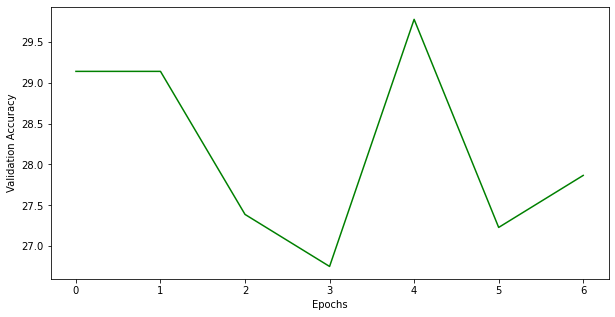

*** Cross Entropy ***


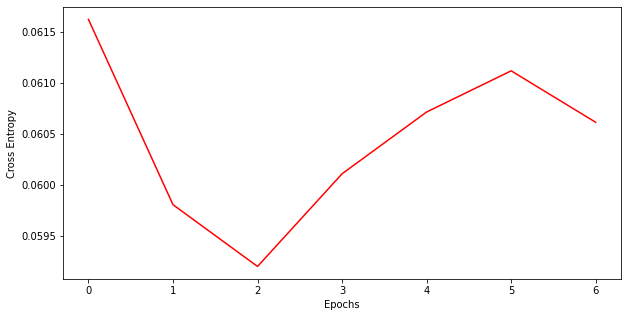

In [28]:
plotting_accuracy(epochs, resnet18_valid_accuracy, 'green', 'Validation Accuracy')
plotting_cros_entropy(epochs, resnet18_cross_entropy, 'red', 'Cross Entropy')

### Testing Model

In [29]:
# Saving Test results in CSV

df = pd.DataFrame()

with torch.no_grad():
    for data in testloader:
        images, labels, paths = data
        images, labels = images.to(device), labels.to(device)
        
        outputs = resnet18(images)
        
        # Applying sigmoid
        outputs = 1 / (1 + np.exp(-torch.Tensor.cpu(outputs).detach().numpy()))
            
        # Converting to 1 if greater than threshold of 0.5
        outputs[:] = np.where(outputs == outputs.max(axis=1).reshape(-1, 1), 1, outputs)
        outputs = np.where(outputs >= 0.5, 1, 0)

         
        images_paths = pd.DataFrame(paths)[0].str.split("/", expand = True).iloc[:,-1]
        current_batch_df = pd.concat([images_paths, pd.DataFrame(outputs)], axis=1, join='inner')
        
        # Changing columns' positions as instructed in the assignment brief  
        columns_titles = [9, 0, 2, 1]
        current_batch_df = current_batch_df.reindex(columns=columns_titles)
        
        current_batch_df.columns = [''] * len(current_batch_df.columns)
        current_batch_df.index = [''] * len(current_batch_df.index)
        
        df = df.append(current_batch_df)

# Restarting DataFrame's index
df.reset_index(drop=True)

# Saving to CSV
df.to_csv('MSDS19069_results4.csv', index=False, header=False)
print('ResNet-18 Test Results Saved in CSV.')

ResNet-18 Test Results Saved in CSV.


In [30]:
import torch
torch.cuda.empty_cache()